In [1]:
#to make life easier
%load_ext autoreload
%autoreload 2

In [2]:
import autograd.numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
import warnings

import plotly.offline as py
py.init_notebook_mode(connected=False)
import plotly.graph_objs as go

<body>
  <p style="color:red";>Due to a scipy latest update, may have to run twice the cell below</p>
</body>


[See issue on the Github](https://github.com/HIPS/autograd/issues/501) for a quick fix

In [3]:
from src.models import Model, Prior, Conditional_model
from src.sampling import Metropolis_Hastings as MH
from src.helpers import samples_exploration,big_plot,reset_plot
from src.optimization import gradient_descent as GD

# Load the data

In [4]:
df = pd.read_csv("data/wages.dat", 
                 sep="\s+")

y_not_normalized = df.LNWAGE.values.copy()

#normalization of continuous variables
df.LNWAGE = (df.LNWAGE - np.mean(df.LNWAGE.values))/np.std(df.LNWAGE.values)
df.ED =(df.ED - np.mean(df.ED.values))/np.std(df.ED.values)
df.EX =(df.EX - np.mean(df.EX.values))/np.std(df.EX.values)

#dropping correlated variables
df = df.drop(columns = ["EXSQ","AGE"], axis = 1)


#building predictors and response matrices
predictors_name = np.array(['ED', 'SOUTH', 'NONWH', 'HISP', 'FE', 'MARR', 'MARRFE', 'EX',
        'UNION', 'MANUF', 'CONSTR', 'MANAG', 'SALES', 'CLER',
        'SERV', 'PROF'])
predictors = df[predictors_name]
y = df.LNWAGE.values
X = predictors.values

#splitting train and test
X, X_test, Y, Y_test,y, y_test = train_test_split(X, y, y_not_normalized, test_size=0.2, random_state=42)

# Exploratory analysis

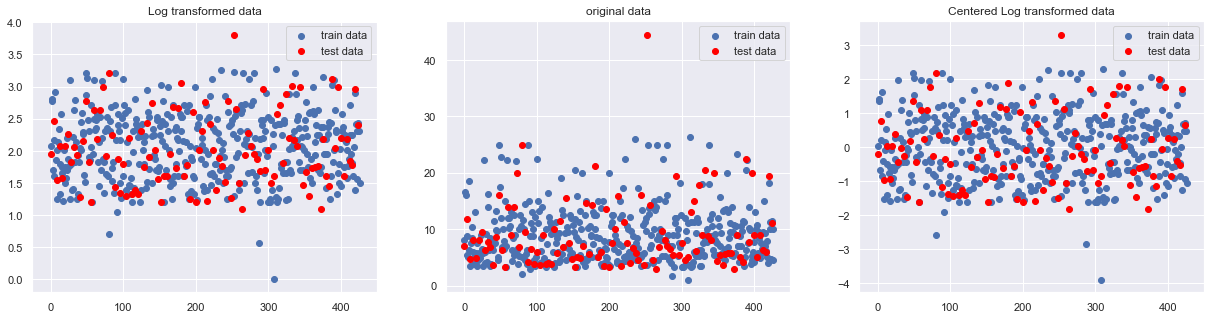

In [5]:
big_plot(21,5)
plt.subplot(132)
plt.scatter(np.arange(len(y)), np.exp(y), label = "train data")
plt.scatter(4*np.arange(len(y_test)), np.exp(y_test), label = "test data", color = "red")
plt.title("original data")
plt.legend()
plt.subplot(131)
plt.scatter(np.arange(len(y)), y, label = "train data")
plt.scatter(4*np.arange(len(y_test)), y_test, label = "test data", color = "red")
plt.title("Log transformed data")
plt.legend()
plt.subplot(133)
plt.scatter(np.arange(len(Y)), Y, label = "train data")
plt.scatter(4*np.arange(len(Y_test)), Y_test, label = "test data", color = "red")
plt.title("Centered Log transformed data")
plt.legend()
plt.show()

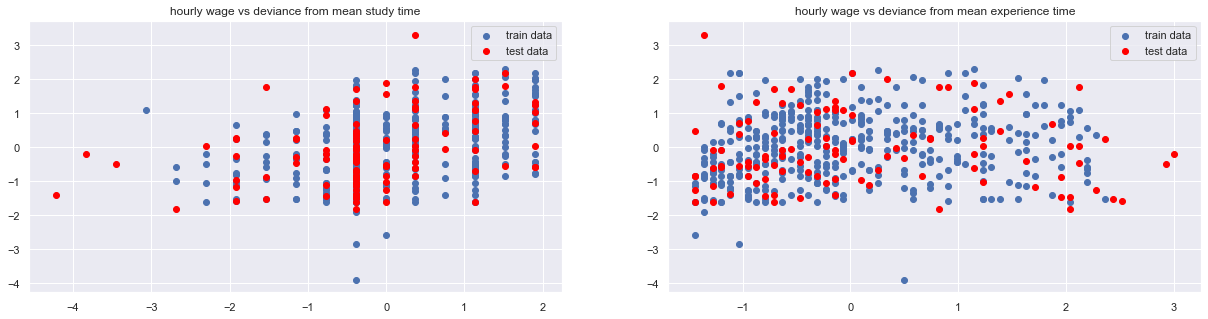

In [6]:
plt.subplot(121)
plt.scatter(X[:,0],Y,label = "train data")
plt.scatter(X_test[:,0],Y_test, label = "test data", color = "red")
plt.legend()
plt.title("hourly wage vs deviance from mean study time")
plt.subplot(122)
plt.scatter(X[:,7],Y, label = "train data")
plt.scatter(X_test[:,7],Y_test, label = "test data", color = "red")
plt.legend()
plt.title("hourly wage vs deviance from mean experience time")
plt.show()

# Create the models

In [7]:
model_gaussian = Model.Model(Prior.Gaussian_exp_prior,Conditional_model.Gaussian, Prior = [0,3,2], data = X, response = Y, additional_param = 1)
model_student = Model.Model(Prior.Gaussian_gamma_prior, Conditional_model.Student, Prior = [0,3,2,1/4], data = X, response = Y, additional_param = 1)

# Obtaining estimates

## Using Ordinary least squares as a comparison

In [8]:
beta_OLS = np.linalg.inv(X.T@X)@X.T@Y
sigma_OLS = (Y-X@beta_OLS).T@(Y-X@beta_OLS)/(len(Y)-len(beta_OLS))
theta_OLS = np.insert(beta_OLS,0,sigma_OLS)

## using MAP

#### using vanilla gradient descent

In [9]:
GD.vanilla_gd(model_gaussian, max_iter= 8000)
GD.vanilla_gd(model_student, max_iter= 8000)

Progress : [====================] 100% Done...
   duration: 0:00:16
Progress : [====================] 100% Done...
   duration: 0:00:20


#### using line search

In [10]:
GD.line_search_gd(model_gaussian, lambda_ = 1e-3,x0 = np.ones(model_gaussian.size),max_iter = 8000)

Progress : [====================] 100% Done...
 converged early at iteration 797

In [11]:
GD.line_search_gd(model_student, lambda_ = 1e-2,x0 = np.ones(model_student.size),max_iter = 8000)

Progress : [====================] 100% Done...
 

#### using Wolfe condition to adpat the step size

In [12]:
GD.Wolfe_cond_gd(model_gaussian, max_iter = 4000, c1 = 1e-1, initial= 0.5*np.ones(model_gaussian.size))

Progress : [====================] 100% Done...
   duration: 0:00:29


In [13]:
GD.Wolfe_cond_gd(model_student, max_iter = 4000, c1 = 1e-1, initial= 0.5*np.ones(model_student.size))

Progress : [====================] 100% Done...
   duration: 0:00:36


## Using Metropolis Hastings

#### with gaussian random walk

In [14]:
with warnings.catch_warnings(record=True):
    initial = np.random.randn(model_gaussian.size)
    initial[0]=0.5
    MH.random_walk_MH(model_gaussian, max_iter = 20000, verbose = True, step_size = 0.035, initial = initial)

Progress : [====================] 100% Done...
  Acceptance rate : 28.1%  (advised values between 10% and 50%)
  duration: 0:00:14


In [15]:
with warnings.catch_warnings(record=True):
    initial = np.random.randn(model_student.size)
    initial[0]=20
    step_size = np.ones_like(initial)*0.035
    step_size[0] = 10
    MH.random_walk_MH(model_student, max_iter = 20000, verbose = True, step_size = step_size, initial = initial)

Progress : [====================] 100% Done...
  Acceptance rate : 31.5%  (advised values between 10% and 50%)
  duration: 0:00:12


#### with Langevin correction

In [16]:
with warnings.catch_warnings(record=True):
    initial = np.ones(model_gaussian.size)
    test = MH.Langevin_MH(model_gaussian, max_iter = 20000, initial = initial,verbose = True, tau = 1e-4,RETURN=True)

Progress : [====================] 100% Done...
  Acceptance rate : 60.0%  (advised values between 10% and 50%)
  duration: 0:01:27


In [17]:
with warnings.catch_warnings(record=True):
    initial = np.ones(model_student.size)
    MH.Langevin_MH(model_student, max_iter = 20000, initial = initial, tau = 1e-4)

Progress : [====================] 100% Done...
  Acceptance rate : 73.3%  (advised values between 10% and 50%)
  duration: 0:02:01


### extraction of the estimates from the models

In [18]:
r_gaussian = model_gaussian()
r_gaussian.T

error         ED     SOUTH     NONWH      HISP  \
gd                  0.773617  0.351707 -0.185607 -0.204573 -0.212707   
line_search_gd      0.773617  0.351707 -0.185607 -0.204573 -0.212708   
Wolfe_cond_gd       0.937500  0.467542  0.014844  0.226920  0.410712   
MH_vanilla_mean     0.790620  0.361481 -0.169784 -0.192417 -0.186899   
MH_vanilla_median   0.789952  0.362930 -0.170248 -0.189062 -0.210471   
MH_Langevin_mean    0.780630  0.347982 -0.183087 -0.203536 -0.240769   
MH_Langevin_median  0.779996  0.348220 -0.181722 -0.200603 -0.234685   

                          FE      MARR    MARRFE        EX     UNION  \
gd                 -0.239068  0.169970 -0.162223  0.258266  0.385554   
line_search_gd     -0.239071  0.169967 -0.162219  0.258266  0.385554   
Wolfe_cond_gd      -0.229593 -0.202774 -0.022500  0.332110  0.352425   
MH_vanilla_mean    -0.218686  0.191485 -0.160051  0.263388  0.376664   
MH_vanilla_median  -0.224004  0.190068 -0.157188  0.263880  0.376562   
MH_Langevin_mean   -0.240428  0.163634 -0.154739  0.256735  0.387041   
MH_Langevin_median -0.245107  0.162695 -0.148100  0.256782  0.388067   

                       MANUF    CONSTR     MANAG     SALES      CLER  \
gd                  0.212763  0.141788  0.393540 -0.297684  0.025752   
line_search_gd      0.212764  0.141789  0.393543 -0.297681  0.025755   
Wolfe_cond_gd       0.328985  0.457122  0.419534  0.369744  0.224076   
MH_vanilla_mean     0.198186  0.096602  0.358541 -0.375483 -0.018304   
MH_vanilla_median   0.192832  0.093044  0.355712 -0.385203 -0.014008   
MH_Langevin_mean    0.216814  0.130555  0.388240 -0.300330  0.034835   
MH_Langevin_median  0.217896  0.135552  0.388512 -0.301875  0.038902   

                        SERV      PROF  
gd                 -0.345085  0.297531  
line_search_gd     -0.345082  0.297534  
Wolfe_cond_gd       0.208475  0.328472  
MH_vanilla_mean    -0.384492  0.254266  
MH_vanilla_median  -0.383190  0.257167  
MH_Langevin_mean   -0.355529  0.311614  
MH_Langevin_median -0.353653  0.315771

In [19]:
r_student = model_student()
r_student.T

error         ED     SOUTH     NONWH      HISP  \
gd                   6.697416  0.339460 -0.204362 -0.240664 -0.297204   
line_search_gd      18.744119  0.341741 -0.197535 -0.220067 -0.256264   
Wolfe_cond_gd        6.339830  0.339387 -0.204712 -0.242420 -0.299998   
MH_vanilla_mean     23.986053  0.343265 -0.200479 -0.205328 -0.204499   
MH_vanilla_median   22.874595  0.341993 -0.200867 -0.203350 -0.200835   
MH_Langevin_mean     9.612079  0.335631 -0.208231 -0.229009 -0.281978   
MH_Langevin_median   9.541018  0.336609 -0.208945 -0.231512 -0.280505   

                          FE      MARR    MARRFE        EX     UNION  \
gd                 -0.265278  0.207148 -0.187853  0.264395  0.365795   
line_search_gd     -0.251051  0.190463 -0.178088  0.260819  0.373601   
Wolfe_cond_gd      -0.267034  0.207635 -0.187642  0.264635  0.365522   
MH_vanilla_mean    -0.241347  0.192443 -0.185723  0.264160  0.379930   
MH_vanilla_median  -0.240190  0.184642 -0.179311  0.263583  0.383215   
MH_Langevin_mean   -0.280495  0.190666 -0.164570  0.260089  0.376120   
MH_Langevin_median -0.289173  0.191081 -0.154324  0.259712  0.377427   

                       MANUF    CONSTR     MANAG     SALES      CLER  \
gd                  0.205217  0.122498  0.503619 -0.280446  0.059612   
line_search_gd      0.206468  0.129351  0.461792 -0.290331  0.042638   
Wolfe_cond_gd       0.205477  0.122620  0.506597 -0.278924  0.061327   
MH_vanilla_mean     0.201679  0.075771  0.443215 -0.310086  0.045969   
MH_vanilla_median   0.206652  0.062901  0.436139 -0.313927  0.047393   
MH_Langevin_mean    0.210818  0.109667  0.490683 -0.272332  0.064951   
MH_Langevin_median  0.211958  0.116390  0.485903 -0.275522  0.065074   

                        SERV      PROF  
gd                 -0.359480  0.313081  
line_search_gd     -0.351271  0.308540  
Wolfe_cond_gd      -0.359544  0.313935  
MH_vanilla_mean    -0.364481  0.303540  
MH_vanilla_median  -0.366805  0.308329  
MH_Langevin_mean   -0.337063  0.329959  
MH_Langevin_median -0.332485  0.328311

In [20]:
trace = []
for name in r_student.columns:
    trace0 = go.Scatter(
    y = r_student[name].values[1:],
    name = name+ " student",
    mode = 'markers',
    marker = dict(
        size = 10,
        color = 'red',
        )
    )
    trace.append(trace0)
for name in r_gaussian.columns:
    trace0 = go.Scatter(
    y = r_gaussian[name].values[1:],
    name = name+ " gaussian",
    mode = 'markers',
    marker = dict(
        size = 10,
        color = 'steelblue',
        )
    )
    trace.append(trace0)

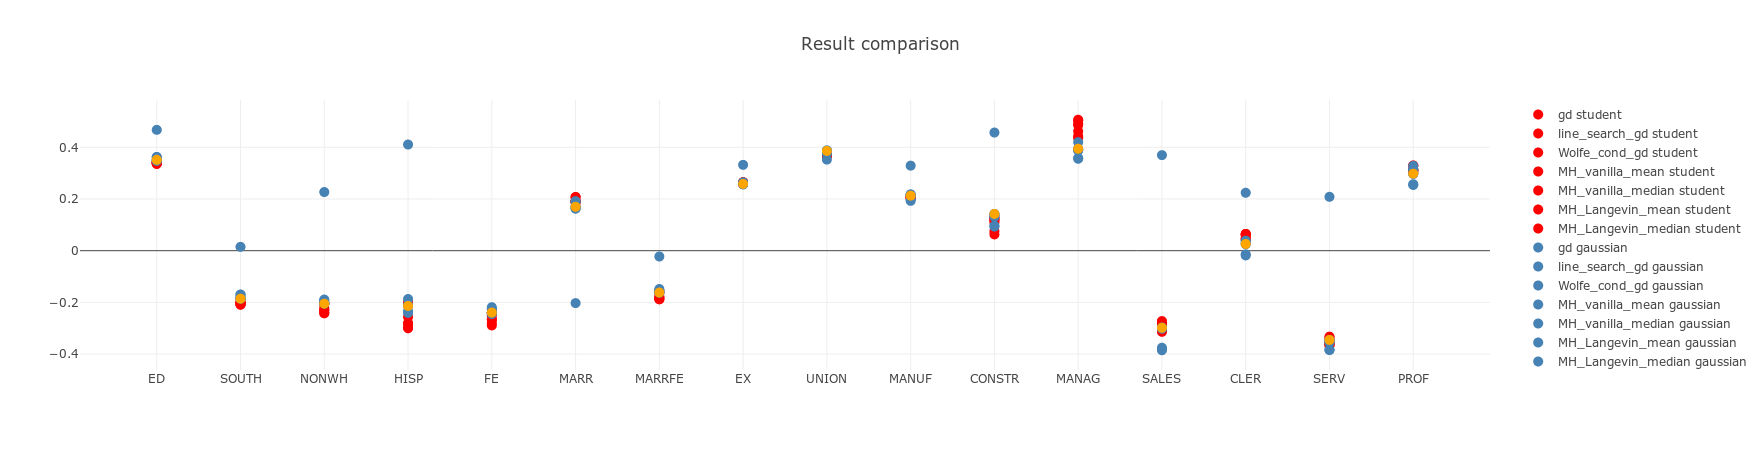

In [21]:
trace_ref = go.Scatter(
    y = theta_OLS[1:],
    name = 'OLS estimate for gaussian model',
    mode = 'markers',
    marker = dict(
        size = 10,
        color = 'orange'
    )
)



trace.append(trace_ref)
data = trace

layout = dict(title = 'Result comparison',
              yaxis = dict(zeroline = True),
               xaxis = go.layout.XAxis(
                        tickmode = 'array',
                        tickvals = np.arange(0,16),
                        ticktext = predictors_name,#np.insert(predictors_name,0,"noise"),
                       zeroline = False
               )
             )

fig = dict(data=data, layout=layout)
py.iplot(fig)

# Accuracy of the prediction

In [22]:
errors_student = pd.DataFrame()
for name in r_student.columns:
    beta = r_student[name].values[1:]
    errors_student[name] = [np.sum(np.abs(Y_test-np.dot(X_test,beta)))/len(Y_test)]
errors_student.index = ["average error"]
errors_student.T

average error
gd                       0.685283
line_search_gd           0.685159
Wolfe_cond_gd            0.685284
MH_vanilla_mean          0.684783
MH_vanilla_median        0.685417
MH_Langevin_mean         0.682980
MH_Langevin_median       0.682634

In [23]:
errors_gaussian = pd.DataFrame()
for name in r_gaussian.columns:
    beta = r_gaussian[name].values[1:]
    errors_gaussian[name] = [np.sum(np.abs(Y_test-np.dot(X_test,beta)))/len(Y_test)]
errors_gaussian.index = ["average error"]
errors_gaussian.T

average error
gd                       0.685706
line_search_gd           0.685706
Wolfe_cond_gd            0.738525
MH_vanilla_mean          0.689058
MH_vanilla_median        0.688247
MH_Langevin_mean         0.686818
MH_Langevin_median       0.686626

# Classification 

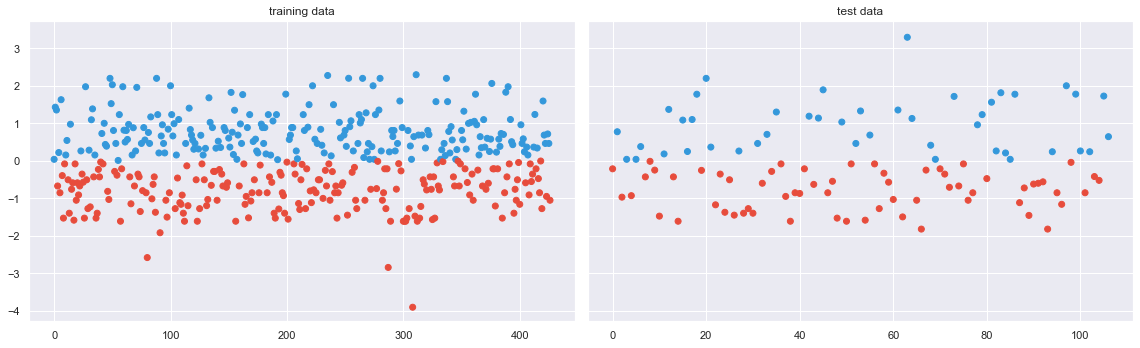

In [24]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5), sharey=True)

inter = Y
classes = inter.copy()
classes[Y >= 0] = 0
classes[Y < 0 ]= 1

#flatui = ["#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
flatui = ["#3498db", "#e74c3c", "#34495e", "#2ecc71"]

def convert(n): 
    return flatui[int(n)]
colors = list(map(convert, classes) )

axs[0].scatter(np.arange(0,X.shape[0]),Y, c = colors)
axs[0].set_title("training data")


inter = Y_test
classes_test = inter.copy()
classes_test[Y_test >= 0] = 0
classes_test[Y_test < 0 ]= 1
colors = list(map(convert, classes_test) )


axs[1].scatter(np.arange(0,X_test.shape[0]),Y_test, c = colors)
axs[1].set_title("test data")

plt.tight_layout()
plt.show()

In [25]:
multilogi = Model.Model(Prior.Gaussian_prior,Conditional_model.Multilogistic,data = X,response = classes, Prior = [0,np.ones(16)],cond_model = [2])

In [26]:
with warnings.catch_warnings(record = True):
    initial = np.zeros(multilogi.size) + 0.5
    samples_classification_v = MH.random_walk_MH(multilogi, max_iter = 40000, verbose = True, step_size = 1e-1, initial = initial, RETURN=True)

Progress : [====================] 100% Done...
  Acceptance rate : 36.4%  (advised values between 10% and 50%)
  duration: 0:00:21


iterations


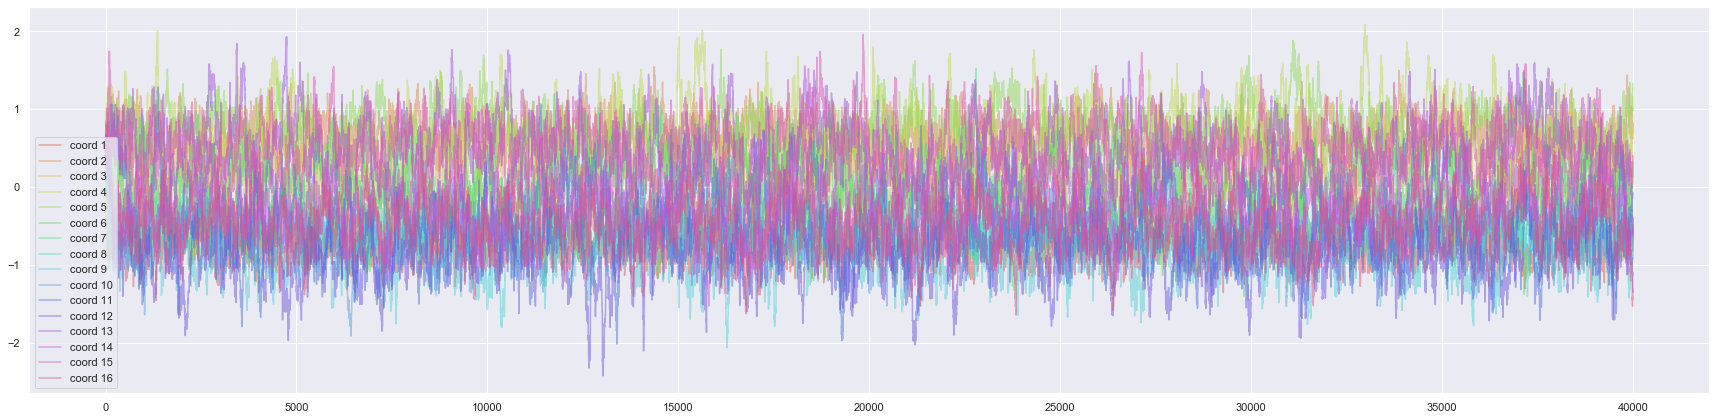

In [27]:
with warnings.catch_warnings(record = True):
    samples_exploration(samples_classification_v, distribution=False, correlation= False)

In [28]:
with warnings.catch_warnings(record = True):
    initial = np.zeros(multilogi.size) + 0.1
    samples_classification_L = MH.Langevin_MH(multilogi, max_iter = 40000, verbose = True, initial = initial, tau = 1e-2,RETURN=True)

Progress : [====================] 100% Done...
  Acceptance rate : 17.1%  (advised values between 10% and 50%)
  duration: 0:01:13


iterations


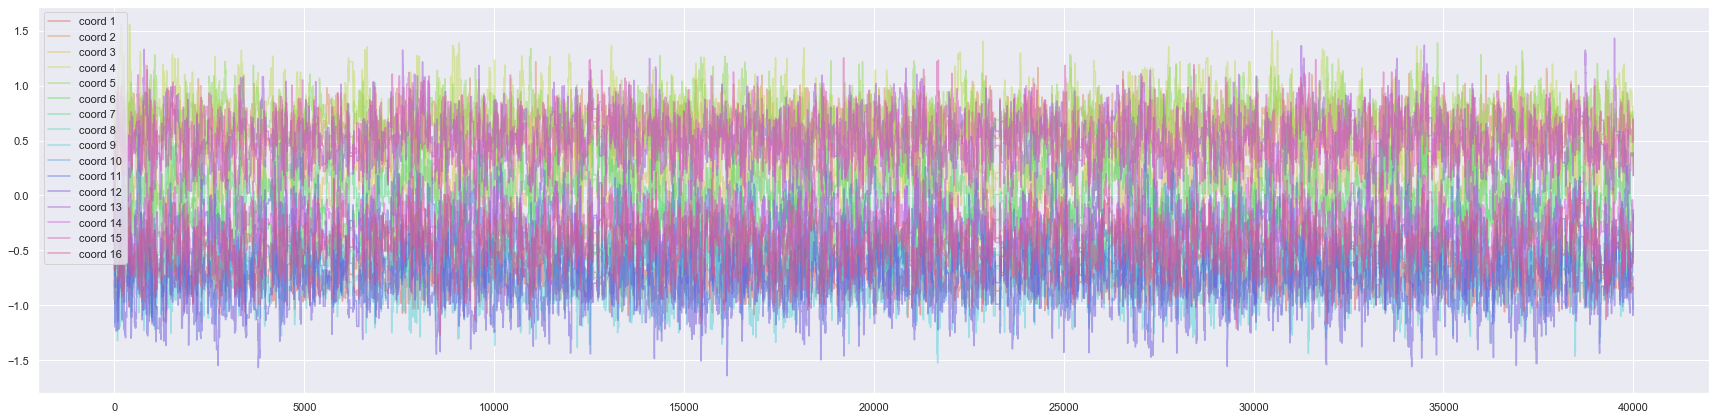

In [29]:
with warnings.catch_warnings(record = True):
    samples_exploration(samples_classification_L, distribution=False, correlation= False)

In [30]:
r_multilogi = multilogi()
r_multilogi.T

ED     SOUTH     NONWH      HISP        FE  \
MH_vanilla_mean    -0.771912  0.648447  0.171629  0.540229  0.646262   
MH_vanilla_median  -0.773234  0.650707  0.175688  0.542061  0.653007   
MH_Langevin_mean   -0.756844  0.619320  0.157924  0.583896  0.634676   
MH_Langevin_median -0.756747  0.621920  0.161971  0.583346  0.630489   

                        MARR    MARRFE        EX     UNION     MANUF  \
MH_vanilla_mean    -0.333730  0.028265 -0.577328 -0.848655 -0.582356   
MH_vanilla_median  -0.336388  0.026357 -0.576776 -0.854607 -0.575451   
MH_Langevin_mean   -0.336571  0.026134 -0.563664 -0.810360 -0.581778   
MH_Langevin_median -0.335697  0.030376 -0.562474 -0.804666 -0.579682   

                      CONSTR     MANAG     SALES      CLER      SERV      PROF  
MH_vanilla_mean    -0.441969 -0.812374  0.440301 -0.279330  0.531277 -0.478109  
MH_vanilla_median  -0.432899 -0.818283  0.425054 -0.279671  0.522147 -0.488892  
MH_Langevin_mean   -0.377060 -0.809941  0.490663 -0.265994  0.535107 -0.469515  
MH_Langevin_median -0.374316 -0.806534  0.484784 -0.267699  0.529291 -0.469578

## Results of logistic regression

In [31]:
predictions = multilogi.predict(X_test)
fitted = multilogi.predict(X)

In [32]:
for name in predictions.columns:
    error = 0
    for pred,true in zip(predictions[name],classes_test):
        if pred != true:
            error+=1    
    print(name)
    print(" error on test set {:.2%}".format(error/len(classes_test)))

MH_vanilla_mean
 error on test set 47.66%
MH_vanilla_median
 error on test set 48.60%
MH_Langevin_mean
 error on test set 43.93%
MH_Langevin_median
 error on test set 43.93%


In [33]:
for name in predictions.columns:
    error = 0
    for pred,true in zip(predictions[name],classes):
        if pred != true:
            error+=1    
    print(name)
    print(" error on train set {:.2%}".format(error/len(classes)))

MH_vanilla_mean
 error on train set 27.87%
MH_vanilla_median
 error on train set 28.10%
MH_Langevin_mean
 error on train set 27.40%
MH_Langevin_median
 error on train set 27.40%


In [73]:
import src.approximation

In [74]:
help(src.approximation)

Help on package src.approximation in src:

NAME
    src.approximation

DESCRIPTION
    module for the approximation methods seen in course.
    Contains:
        - laplace approximation
        - GVA approximation

PACKAGE CONTENTS
    Gaussian_variational_approximation
    Laplace
    approximation_

FILE
    /home/charles/Desktop/Bayesian computation/projet_bayesian/src/approximation/__init__.py


